# 基于瓜子二手车数据的二手电动车价格分析以及折价率分析模型

In [153]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 数据读取

In [154]:
allData = pd.read_csv('../crawl_for_guazi/data.csv')
print(allData.shape)
allData.head()

(702, 15)


,id,car_name,car_brand,car_tag,price,new_price,complexOutlook,firstCert,odograph,allPower,carBelong,range,isDome,wheelBase,drivingMode
0,116458848,特斯拉 Model 3 2020款 改款 标准续航后驱升级版,特斯拉,Model 3,218000,292751,9成新,2020-12,2.6万公里,202kW,太原(晋),468km,0,2875,后置后驱
1,116339799,宝骏E100 2020款 305KM 智行版,宝骏,宝骏E100,41800,54056,9成新,2021-02,0.4万公里,24kW,台州(浙),305km,1,1600,前置前驱
2,115943401,比亚迪 汉 2020款 EV 四驱高性能版旗舰型,比亚迪,汉,229000,308816,9成新,2020-08,1.9万公里,363kW,成都(川),550km,1,2920,双电机四驱
3,116482432,特斯拉 Model 3 2021款 Performance高性能全轮驱动版,特斯拉,Model 3,306700,368951,9成新,2021-03,1.9万公里,339kW,重庆(渝),605km,0,2875,双电机四驱
4,115679152,特斯拉MODEL S 2014款 MODEL S 85,特斯拉,特斯拉MODEL S,258000,796735,7成新,2015-02,4.7万公里,270kW,烟台(鲁),502km,0,2960,后置后驱


In [155]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              702 non-null    int64 
 1   car_name        702 non-null    object
 2   car_brand       702 non-null    object
 3   car_tag         702 non-null    object
 4   price           702 non-null    int64 
 5   new_price       702 non-null    int64 
 6   complexOutlook  702 non-null    object
 7   firstCert       702 non-null    object
 8   odograph        702 non-null    object
 9   allPower        702 non-null    object
 10  carBelong       702 non-null    object
 11  range           702 non-null    object
 12  isDome          702 non-null    int64 
 13  wheelBase       702 non-null    int64 
 14  drivingMode     702 non-null    object
dtypes: int64(5), object(10)
memory usage: 82.4+ KB


In [156]:
allData.describe()

,id,price,new_price,isDome,wheelBase
count,7.020000e+02,702.000000,702.000000,702.000000,702.000000
mean,1.162133e+08,144376.066952,215793.247863,0.706553,2589.311966
std,2.967665e+05,103515.876549,141505.138763,0.455666,365.810902
min,1.130053e+08,12800.000000,0.000000,0.000000,1600.000000
25%,1.159859e+08,59050.000000,86620.000000,0.000000,2452.500000
50%,1.163003e+08,106400.000000,192996.000000,1.000000,2670.000000
75%,1.164230e+08,229000.000000,305017.000000,1.000000,2875.000000
max,1.165605e+08,728000.000000,947506.000000,1.000000,3110.000000


## 数据清洗

1. 该部分目的为将带单位的属性变为纯数字型属性，如将“7成新”变为“7”，以及时间属性，里程去单位
2. 具体的：
   1. 将成色属性去除尾部中文，并转换为float类型
   2. 将上牌年月属性转为时间单位，并增加一列“使用时间“，表示从首次上牌至今的天数
   3. 表显里程以纯数字形式显示，注意列表中带有”万“时需乘10000
   4. 车辆总功率去单位
   5. 续航里程去单位

### 1. 处理外观成色属性字段，将其转换为float类型

In [157]:
def dealOutlookStr(str):
    if type(str) is float:
        return str
    str = str.rstrip('成新')
    if len(str) > 1 and '.' not in str:
        str = float(str) / 10
    return str

allData['complexOutlook'] = allData['complexOutlook'].map(lambda x: np.float(dealOutlookStr(x)))
allData['complexOutlook'].describe()

count    702.000000
mean       8.696296
std        0.811622
min        6.000000
25%        8.000000
50%        9.000000
75%        9.000000
max        9.900000
Name: complexOutlook, dtype: float64

### 2. 将首次上牌修改为pandas.datetime形式，并新增一列表示从上牌至数据获取时(2022-01-26)的天数



In [158]:
allData['firstCert'] = pd.to_datetime(allData['firstCert'],format='%Y-%m')
allData['daysGone'] = ((pd.to_datetime('2022-02-26') - allData['firstCert']).dt.days)
allData['daysGone']

0       452
1       390
2       574
3       362
4      2582
       ... 
697     818
698     482
699    1183
700    1701
701     209
Name: daysGone, Length: 702, dtype: int64

### 3. 处理表显里程数

In [159]:
def dealOdograph(str):
    if type(str) is float:
        return str
    str = str.rstrip('公里')
    if '万' in str:
        str = str.rstrip('万')
        str = float(str) * 10000
    return float(str)

allData['odograph'] = allData['odograph'].map(dealOdograph)
allData['odograph'].describe()

count       702.000000
mean      20470.655271
std       20186.149243
min         100.000000
25%        5000.000000
50%       15500.000000
75%       30000.000000
max      142000.000000
Name: odograph, dtype: float64

### 4. 处理车辆总功率

In [160]:
allData['allPower'] = allData['allPower'].map(lambda x: float(x.rstrip('kW')))

In [161]:
# 处理车辆续航里程
allData['range'].describe()
# temp = allData['range'].map(lambda x: 'km' in x)
# temp.unique()
def dealRange(str):
    if str is '-' or str is None:
        return None
    if type(str) is int:
        return str
    str = str.rstrip('km')
    return int(str)
allData['range'] = allData['range'].map(dealRange)

### 5. 删除new_price为0的行

In [162]:
allData = allData.drop(index=allData[allData['new_price'] == 0].index)

### 6. 添加损耗价格与损耗价格率
depreciation = new_price - price  
%depreciation = depriciation / new_price

In [163]:
def depri(df):
    return df['new_price'] - df['price'] if df['new_price'] - df['price'] > 0 else 0

def depri_per(df):
    return df['depri'] / df['new_price'] if df['new_price'] > 0 else 0

def preserve_per(df):
    return df['price'] / df['new_price'] if df['new_price'] > 0 else 0

allData['depri'] = allData.apply(depri, axis=1)
allData['depri_ratio'] = allData.apply(depri_per, axis=1)
allData['preserve_ratio'] = allData.apply(preserve_per, axis=1)

### 7. 清洗后的数据描述

In [164]:
allData.describe()

,id,price,new_price,complexOutlook,odograph,allPower,range,isDome,wheelBase,daysGone,depri,depri_ratio,preserve_ratio
count,7.010000e+02,701.000000,701.000000,701.000000,701.000000,701.000000,674.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,1.162131e+08,144379.741797,216101.084165,8.695863,20498.430813,138.421969,375.994065,0.706134,2588.740371,560.875892,71742.289586,0.319774,0.680625
std,2.969125e+05,103589.744249,141370.756508,0.812121,20187.134102,104.506634,153.989328,0.455857,365.758251,468.654771,71071.290040,0.206324,0.207029
min,1.130053e+08,12800.000000,31261.000000,6.000000,100.000000,15.000000,52.000000,0.000000,1600.000000,25.000000,0.000000,0.000000,0.077174
25%,1.159856e+08,58800.000000,86620.000000,8.000000,5000.000000,42.000000,270.000000,0.000000,2450.000000,209.000000,21965.000000,0.168351,0.556648
50%,1.163001e+08,106000.000000,192996.000000,9.000000,16000.000000,132.000000,400.000000,1.000000,2670.000000,452.000000,54547.000000,0.260122,0.739878
75%,1.164231e+08,229000.000000,305017.000000,9.000000,30000.000000,202.000000,500.000000,1.000000,2875.000000,818.000000,92894.000000,0.443352,0.831649
max,1.165605e+08,728000.000000,947506.000000,9.900000,142000.000000,577.000000,712.000000,1.000000,3110.000000,2582.000000,538735.000000,0.922826,1.120087


## 数据分析

### 1. 查看折价率为0的行  
车辆的二手价格甚至超过了新车的价格，这是不常见的

In [165]:
allData[allData['preserve_ratio'] > 1]

,id,car_name,car_brand,car_tag,price,new_price,complexOutlook,firstCert,odograph,allPower,carBelong,range,isDome,wheelBase,drivingMode,daysGone,depri,depri_ratio,preserve_ratio
408,116433745,零跑汽车 零跑T03 2020款 400标准版,零跑汽车,零跑T03,80000,71423,9.0,2021-06-01,14000.0,55.0,温州(浙),403.0,0,2400,前置前驱,270,0,0.0,1.120087
525,115705191,五菱汽车 宏光MINI EV 2020款 轻松款 磷酸铁锂,五菱,宏光MINI EV,33000,31261,9.5,2021-06-01,2000.0,20.0,唐山(冀),120.0,1,1940,后置后驱,270,0,0.0,1.055628
648,115701297,五菱汽车 宏光MINI EV 2020款 悦享款 磷酸铁锂,五菱,宏光MINI EV,42800,42116,9.5,2022-01-01,100.0,20.0,安顺(贵),170.0,1,1940,后置后驱,56,0,0.0,1.016241
696,116304498,五菱汽车 宏光MINI EV 2020款 悦享款 磷酸铁锂,五菱,宏光MINI EV,45800,42116,9.0,2021-01-01,9000.0,20.0,上海(沪),170.0,1,1940,后置后驱,421,0,0.0,1.087473


### 2. 对特征与保值率做可视化统计

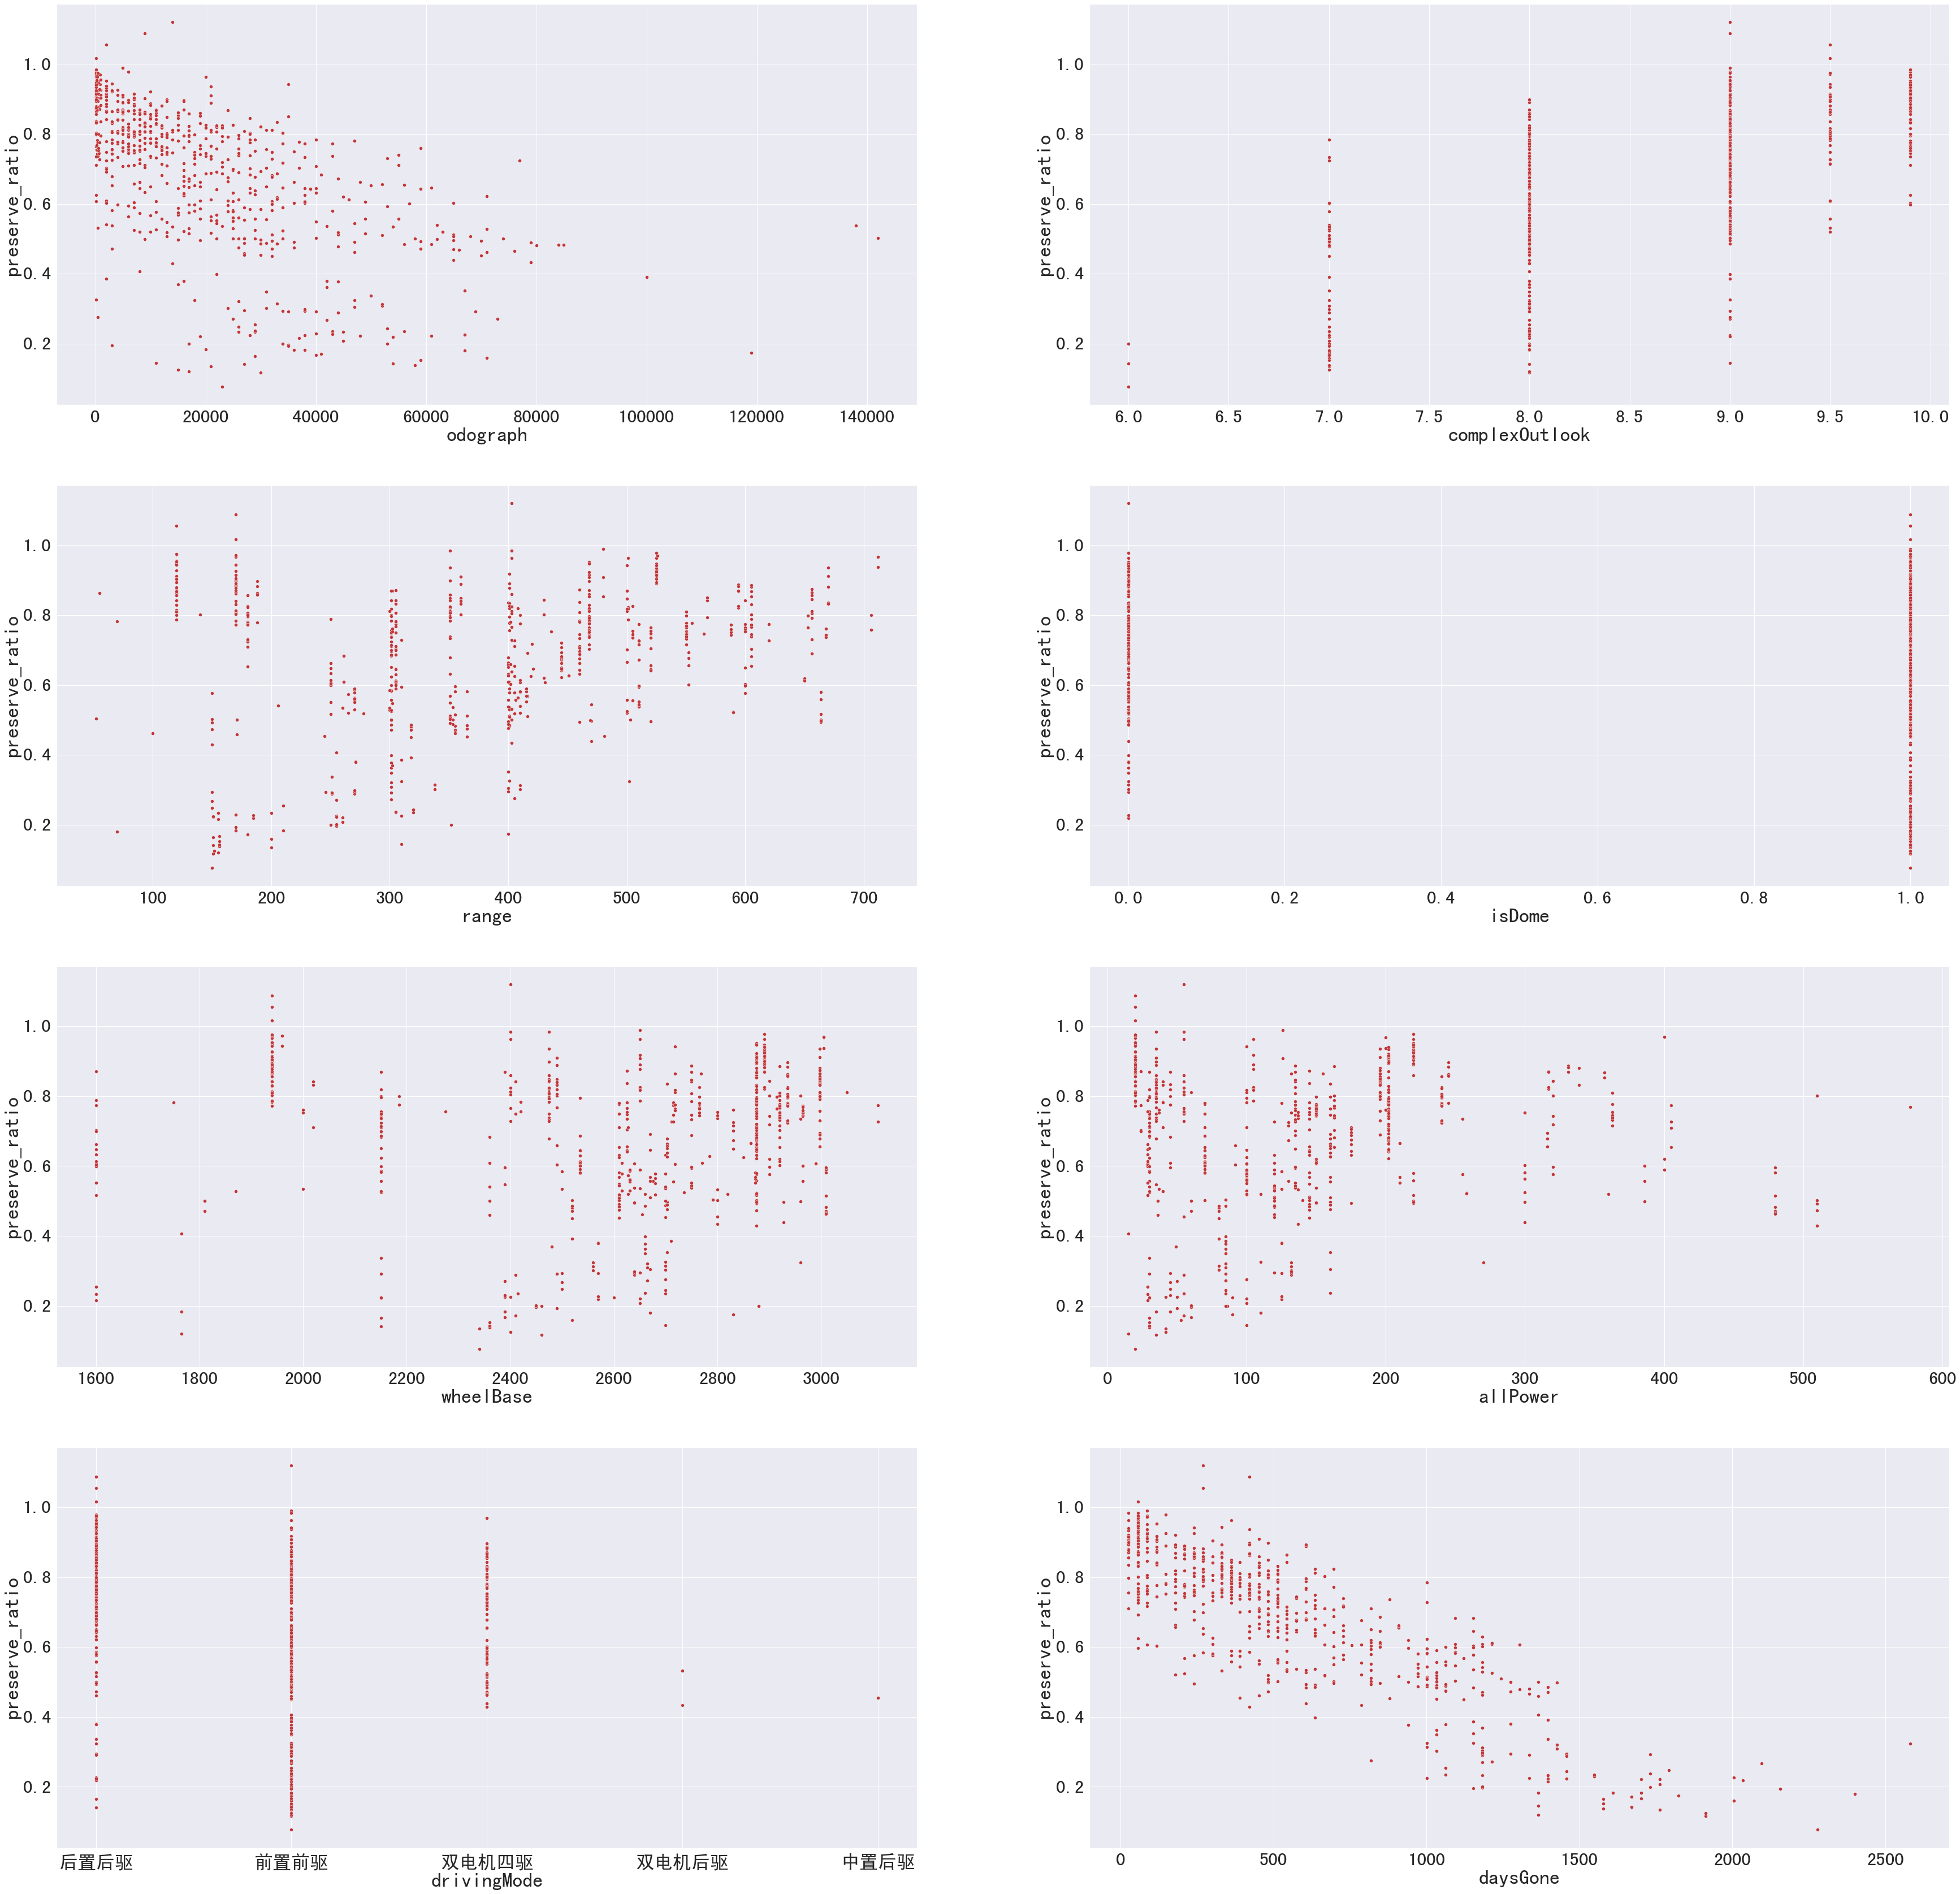

In [166]:
rc = {'font.sans-serif': 'SimHei', 'axes.unicode_minus': False}
sns.set(rc=rc, palette = "RdBu", font_scale = 3)
figure, axes = plt.subplots(4, 2, figsize=(60,60))
sns.scatterplot(allData['odograph'], allData['preserve_ratio'], ax=axes[0][0])
sns.scatterplot(allData['complexOutlook'], allData['preserve_ratio'], ax=axes[0][1])
sns.scatterplot(allData['range'], allData['preserve_ratio'], ax=axes[1][0])
sns.scatterplot(allData['isDome'], allData['preserve_ratio'], ax=axes[1][1])
sns.scatterplot(allData['wheelBase'], allData['preserve_ratio'], ax=axes[2][0])
sns.scatterplot(allData['allPower'], allData['preserve_ratio'], ax=axes[2][1])
sns.scatterplot(allData['drivingMode'], allData['preserve_ratio'], ax=axes[3][0])
sns.scatterplot(allData['daysGone'], allData['preserve_ratio'], ax=axes[3][1])
plt.show()

### 3. 筛选排名靠前的品牌并查看相关性

In [167]:
dict = allData['car_brand'].value_counts()
dict.sort_values(ascending=True)
dict = dict[:10]

tempdf = allData[allData['car_brand'].isin(dict.keys())]
tempdf.describe()

,id,price,new_price,complexOutlook,odograph,allPower,range,isDome,wheelBase,daysGone,depri,depri_ratio,preserve_ratio
count,5.060000e+02,506.000000,506.000000,506.000000,506.000000,506.000000,484.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,1.162227e+08,148950.788538,203452.389328,8.780237,18892.094862,131.242688,376.964876,0.667984,2567.505929,504.318182,54513.669960,0.266127,0.734188
std,2.705046e+05,104603.994027,133937.728192,0.773167,19307.752938,94.792852,163.333382,0.471403,395.198034,430.800557,56047.029367,0.176747,0.177283
min,1.151689e+08,22000.000000,31261.000000,6.000000,100.000000,20.000000,52.000000,0.000000,1600.000000,25.000000,0.000000,0.000000,0.135017
25%,1.159859e+08,53000.000000,80107.000000,8.000000,5000.000000,35.000000,250.000000,0.000000,2360.000000,209.000000,18477.000000,0.136819,0.644728
50%,1.163178e+08,115900.000000,192996.000000,9.000000,13000.000000,145.000000,365.000000,1.000000,2650.000000,421.000000,42761.500000,0.224094,0.775906
75%,1.164286e+08,233600.000000,308816.000000,9.000000,28000.000000,202.000000,520.000000,1.000000,2890.000000,666.000000,72276.000000,0.355272,0.863181
max,1.165605e+08,728000.000000,947506.000000,9.900000,142000.000000,577.000000,706.000000,1.000000,3050.000000,2582.000000,538735.000000,0.864983,1.087473


<AxesSubplot:xlabel='car_brand', ylabel='preserve_ratio'>

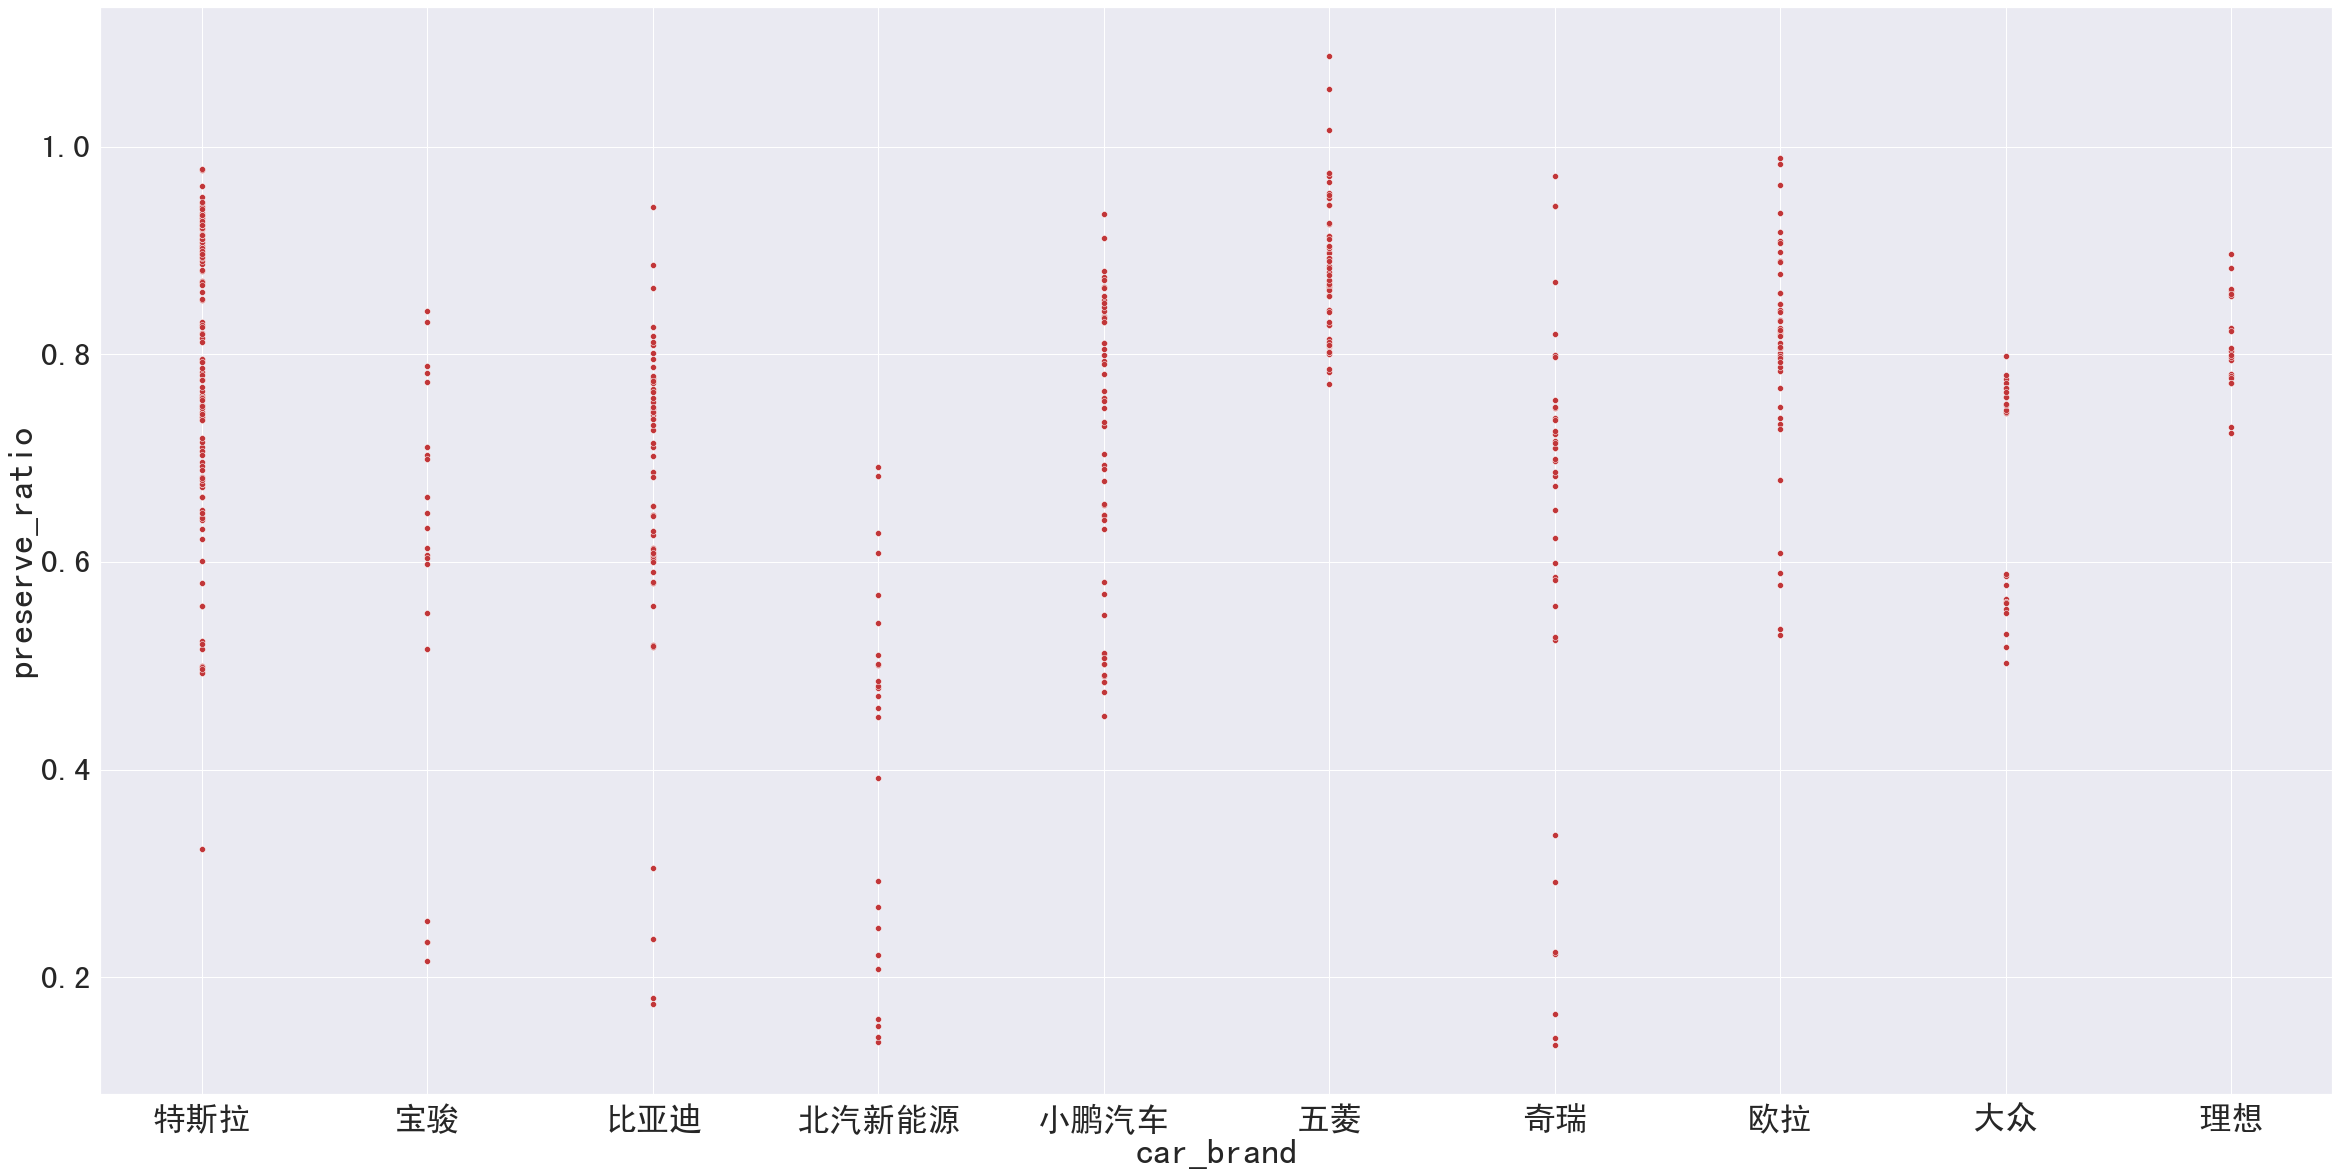

In [168]:
sns.set(rc=rc, palette = "RdBu", font_scale = 3)
figure, axes = plt.subplots(1, 1, figsize=(40,20))
sns.scatterplot(tempdf['car_brand'], tempdf['preserve_ratio'])

### 3. 分地区查看保值率是否与地区有关

In [169]:
dict = allData['carBelong'].value_counts()
dict.sort_values(ascending=True)
dict = dict[:10]

tempdf = allData[allData['carBelong'].isin(dict.keys())]
tempdf.describe()

,id,price,new_price,complexOutlook,odograph,allPower,range,isDome,wheelBase,daysGone,depri,depri_ratio,preserve_ratio
count,3.090000e+02,309.000000,309.000000,309.000000,309.000000,309.00000,300.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,1.162240e+08,162504.203883,242361.912621,8.694822,21430.744337,164.05178,401.400000,0.702265,2678.466019,529.142395,79869.631068,0.317495,0.682789
std,3.141641e+05,98914.850696,137123.298692,0.747185,20851.699449,109.61860,154.775941,0.458004,309.592091,426.884393,68936.283770,0.181065,0.181630
min,1.130053e+08,12800.000000,31261.000000,6.000000,100.000000,20.00000,52.000000,0.000000,1600.000000,25.000000,0.000000,0.000000,0.077174
25%,1.161364e+08,79500.000000,144258.000000,8.000000,6000.000000,85.00000,301.000000,0.000000,2610.000000,240.000000,33838.000000,0.191701,0.561367
50%,1.163043e+08,142800.000000,254868.000000,9.000000,16000.000000,150.00000,403.000000,1.000000,2750.000000,452.000000,62258.000000,0.267008,0.732992
75%,1.164338e+08,232800.000000,316740.000000,9.000000,30000.000000,202.00000,520.000000,1.000000,2890.000000,696.000000,100740.000000,0.438633,0.808299
max,1.165605e+08,728000.000000,947506.000000,9.900000,142000.000000,577.00000,712.000000,1.000000,3050.000000,2401.000000,382902.000000,0.922826,1.087473


<AxesSubplot:xlabel='carBelong', ylabel='preserve_ratio'>

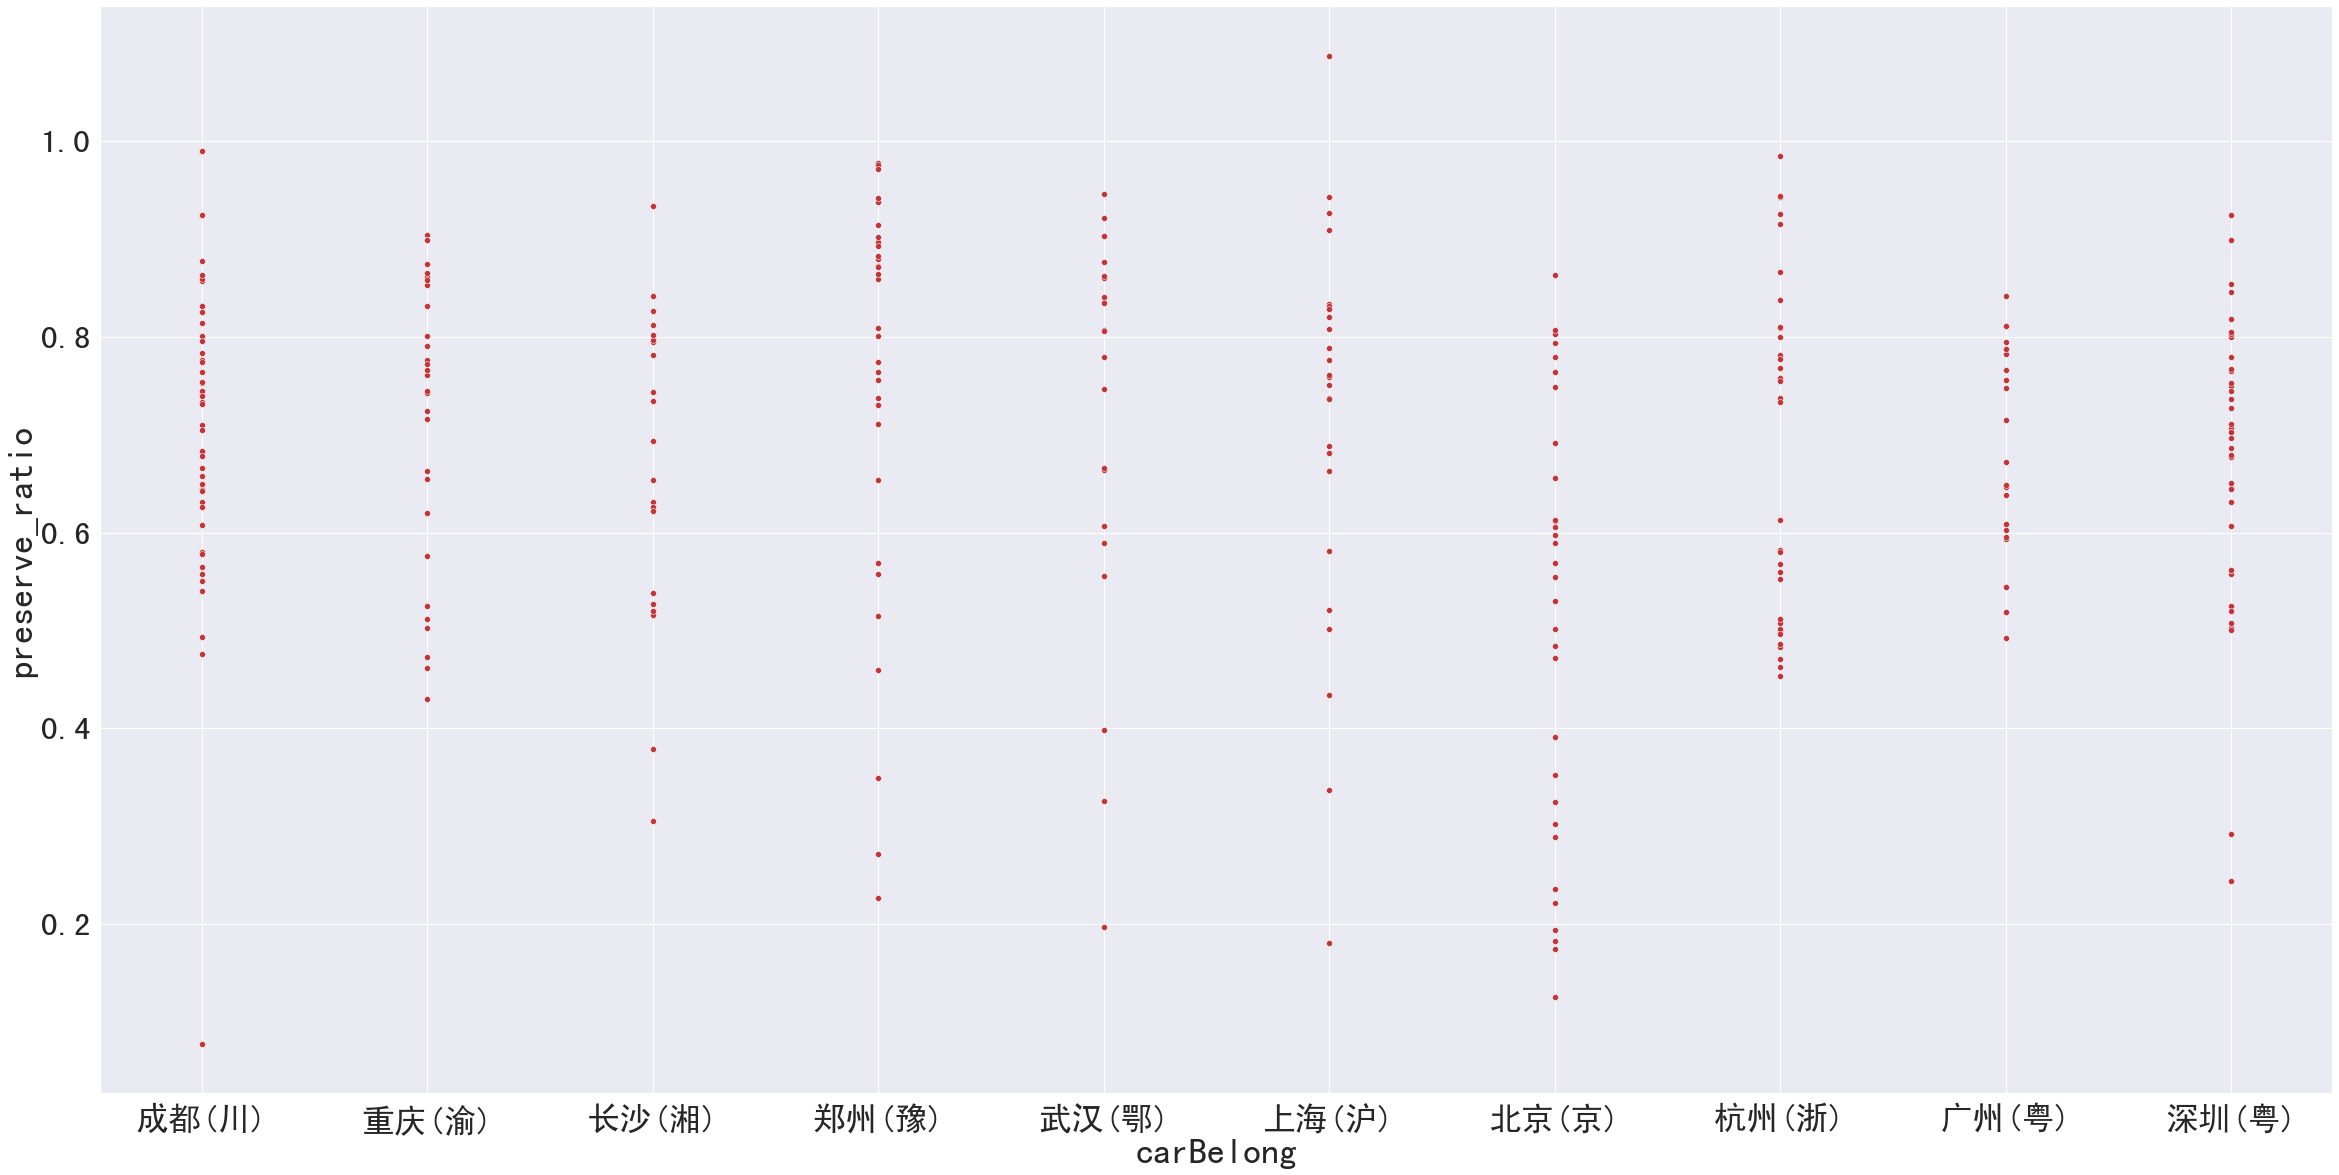

In [170]:
sns.set(rc=rc, palette = "RdBu", font_scale = 3)
figure, axes = plt.subplots(1, 1, figsize=(40,20))
sns.scatterplot(tempdf['carBelong'], tempdf['preserve_ratio'])